Sigma: 0.1, Average SSIM: 0.9178734400185151
Sigma: 0.3, Average SSIM: 0.8863745610139675
Sigma: 0.5, Average SSIM: 0.8310572550812289
Bottleneck Size: 32, Average SSIM: 0.8920877258584929
Bottleneck Size: 64, Average SSIM: 0.8933142243629809
Bottleneck Size: 124, Average SSIM: 0.8931565040820673


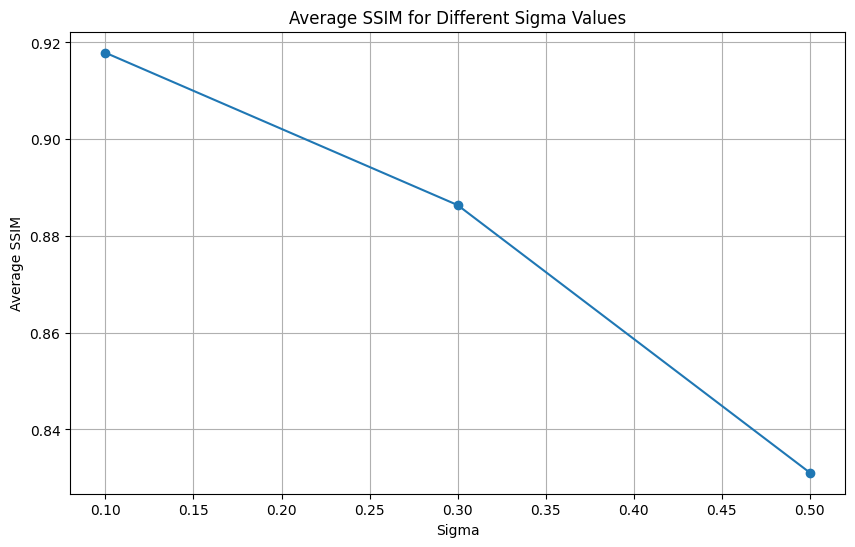

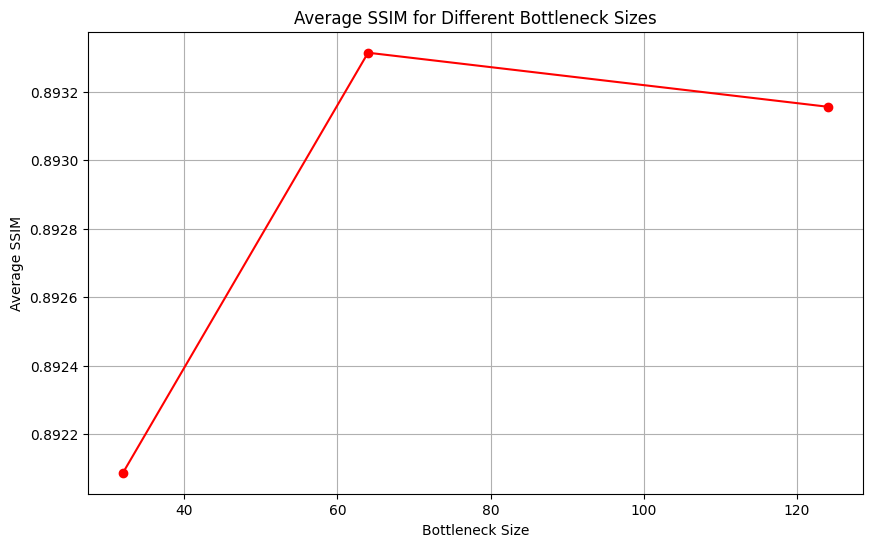

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Loading MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=False)#without interference from batch-wise operations

#gradually increasing the number of feature maps in deeper layers. This process captures increasingly abstract and high-level features of the input image.
class ConvAutoencoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # Output size: [batch, 16, 14, 14], here we have batch size, 16 feature maps and 14x14 dim
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output size: [batch, 32, 7, 7]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7)  # Output size: [batch, 64, 1, 1]
        )
        self.bottleneck = nn.Linear(64 * 1 * 1, bottleneck_size)

        # Decoder
        self.decoder_fc = nn.Linear(bottleneck_size, 64 * 1 * 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # Output size: [batch, 32, 7, 7]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # [batch, 16, 14, 14]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # [batch, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)
        x = self.decoder_fc(x)
        x = x.view(x.size(0), 64, 1, 1)  # Reshaping for the decoder
        x = self.decoder(x)
        return x


# Adding Gaussian Noise
def add_gaussian_noise(images, sigma): #sigma->stdev of gaussian noise
    noise = torch.randn_like(images) * sigma #generating random noise and scaling with sigma
    return images + noise

# SSIM Calculation
def calculate_ssim(original, noisy, data_range):
    ssim_scores = []
    for o, n in zip(original, noisy):
        o = o.squeeze().numpy()
        n = n.squeeze().detach().numpy()
        score = ssim(o, n, data_range=data_range)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Training Function
def train(model, dataloader, optimizer, criterion, sigma):
    model.train()
    for data, _ in dataloader:
        noisy_data = add_gaussian_noise(data, sigma)
        optimizer.zero_grad()
        outputs = model(noisy_data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()

# Testing Function
def test(model, dataloader, sigma):
    model.eval()
    ssim_scores = []
    with torch.no_grad():
        for data, _ in dataloader:
            original = data
            noisy_data = add_gaussian_noise(data, sigma)
            outputs = model(noisy_data)
            ssim_score = calculate_ssim(original, outputs, data_range=1.0)
            ssim_scores.append(ssim_score)
    return np.mean(ssim_scores)

# Parameters
sigmas = [0.1, 0.3, 0.5]
bottleneck_sizes = [32, 64, 124]


sigma_results = []
bottleneck_results = []


for sigma in sigmas:
    model = ConvAutoencoder(bottleneck_size=512)  # Example bottleneck size
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training
    for epoch in range(5):
        train(model, train_loader, optimizer, criterion, sigma)

    # Testing
    avg_ssim = test(model, test_loader, sigma)
    sigma_results.append(avg_ssim)
    print(f"Sigma: {sigma}, Average SSIM: {avg_ssim}")


for size in bottleneck_sizes:
    model = ConvAutoencoder(bottleneck_size=size)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training with constant sigma
    for epoch in range(5):
        train(model, train_loader, optimizer, criterion, sigma=0.3)

    # Testing
    avg_ssim = test(model, test_loader, sigma=0.3)
    bottleneck_results.append(avg_ssim)
    print(f"Bottleneck Size: {size}, Average SSIM: {avg_ssim}")

# Plotting the results
# Plot for different sigma values
plt.figure(figsize=(10, 6))
plt.plot(sigmas, sigma_results, marker='o')
plt.title("Average SSIM for Different Sigma Values")
plt.xlabel("Sigma")
plt.ylabel("Average SSIM")
plt.grid(True)
plt.show()

# Plot for different bottleneck sizes
plt.figure(figsize=(10, 6))
plt.plot(bottleneck_sizes, bottleneck_results, marker='o', color='red')
plt.title("Average SSIM for Different Bottleneck Sizes")
plt.xlabel("Bottleneck Size")
plt.ylabel("Average SSIM")
plt.grid(True)
plt.show()


**Observations for Sigma:**
As the value of sigma increases from 0.1 to 0.5, the average Structural Similarity Index (SSIM) decreases consistently. This indicates that as the magnitude of Gaussian noise added to the input images during training increases, the fidelity of the reconstructed images decreases. A lower SSIM score suggests that the quality of the reconstructed images deteriorates with higher noise levels. Therefore, the model's ability to accurately reconstruct the input images is negatively impacted as the noise level in the input increases.

**Observations for Bottleneck**:- The fluctuation in average SSIM scores across different bottleneck sizes suggests the impact of bottleneck size on the performance of the convolutional autoencoder. Initially, increasing the bottleneck size enhances the model's capacity to capture and represent complex features, resulting in improved reconstruction fidelity. However, as the bottleneck size continues to increase, the model may begin to overfit, leading to a slight degradation in reconstruction quality. This observation underscores the importance of carefully selecting the bottleneck size to strike a balance between model complexity and generalization, thereby optimizing reconstruction accuracy and avoiding overfitting.